In [6]:
import sys
sys.path.append('../../../')
sys.path.append('/home/sheida.rahnamai/GIT/HDN/')
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread
import glob
import matplotlib.patches as patches
import hdbscan as hd
from hdbscan import prediction
from sklearn.cluster import HDBSCAN
from collections import Counter
from openTSNE import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from lib import plotting as p
from lib import dataprep as dp
import random
import umap
from tqdm import tqdm
from lib.evaluation import FeatureExtractor
# from lib.dataloader import CustomTestDataset
from lib.dataloader import CustomDataset
import tifffile as tiff
from sklearn.utils import shuffle
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans


## Loading the model

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

patch_size = 64
sample_size = 131
centre_size = 4
n_channel = 32
hierarchy_level = 3
pad_size = (patch_size - centre_size) // 2
model_dir = "/group/jug/Sheida/HVAE/cl_w_bg_v0/"
# model_dir = "/group/jug/Sheida/HVAE/Hyperparameter_search/legendary-violet-547-2nd-cl1e-3_kl1/"
model = torch.load(model_dir+"model/HVAE_best_vae.net")

### Loading train data
### Sample from different classes
### Loading test data

In [8]:
# train data

# data_dir = "/localscratch/contrastive/"
data_dir = "/localscratch/data/"
# train_img_dir = sorted(glob.glob(data_dir+"train/mito_golgi_gra/*.tif"))
train_img_dir = sorted(glob.glob(data_dir+"high_c1/high_c1_source.tif"))
train_images = tiff.imread(train_img_dir)
# train_label_dir = sorted(glob.glob(data_dir+"train/label_mito_golgi_gra/*.tif"))
train_label_dir = sorted(glob.glob(data_dir+"high_c1/high_c1_gt.tif"))
train_labels = tiff.imread(train_label_dir)



train_images, train_labels = shuffle(train_images, train_labels)

data_mean = np.mean(train_images)
data_std = np.std(train_images)
train_images = (train_images-data_mean)/data_std
# train_set = CustomTestDataset(train_images, train_labels)
train_set = CustomDataset(train_images, train_labels)

golgi_indices = random.sample(train_set.patches_by_label[1],sample_size)
mito_indices = random.sample(train_set.patches_by_label[2],sample_size)
gra_indices = random.sample(train_set.patches_by_label[3],sample_size)

golgi_samples, golgi_cls, golgi_lbl = train_set[golgi_indices]
mito_samples, mito_cls, mito_lbl = train_set[mito_indices]
gra_samples, gra_cls, gra_lbl = train_set[gra_indices]

golgi_samples = golgi_samples.squeeze(1)
golgi_lbl = golgi_lbl.squeeze(1)
mito_samples = mito_samples.squeeze(1)
mito_lbl = mito_lbl.squeeze(1)
gra_samples = gra_samples.squeeze(1)
gra_lbl = gra_lbl.squeeze(1)

#test data

# test_img_dir = sorted(glob.glob(data_dir+"test/mito_golgi_gra/*.tif"))
test_img_dir = sorted(glob.glob(data_dir+"high_c4/high_c4_source.tif"))
test_images = tiff.imread(test_img_dir)
# test_label_dir = sorted(glob.glob(data_dir+"test/label_mito_golgi_gra/*.tif"))
test_label_dir = sorted(glob.glob(data_dir+"high_c4/high_c4_gt.tif"))
test_labels = tiff.imread(test_label_dir)

test_images = (test_images-data_mean)/data_std

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

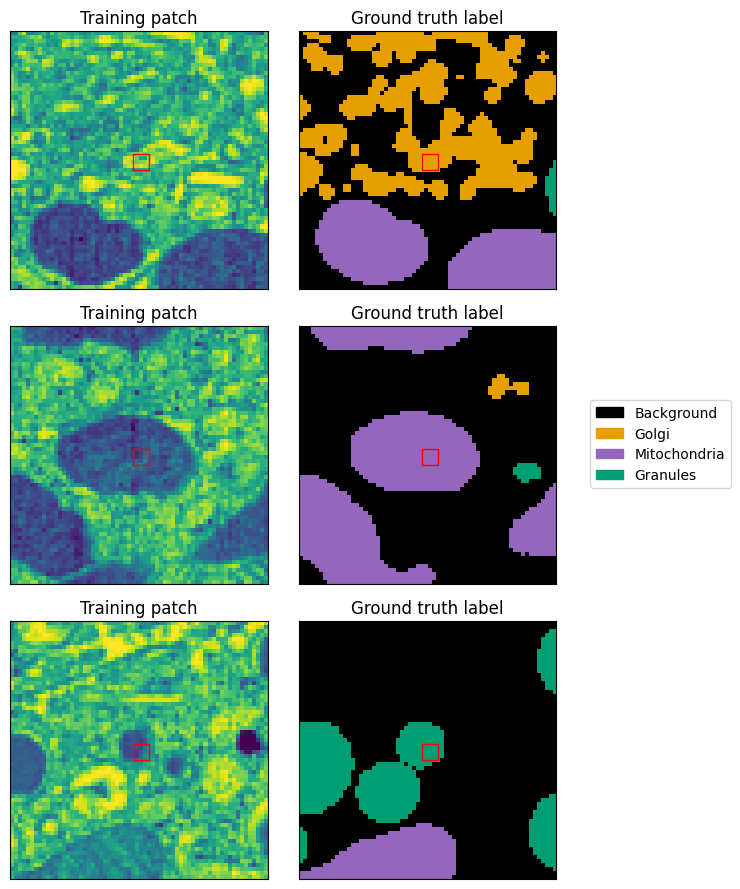

In [33]:
i, j, k = np.random.randint(0, sample_size, 3)
p.plot_wo_b((golgi_samples[i], 'Training patch', (pad_size, pad_size, centre_size)),\
        (golgi_lbl[i], 'Ground truth label', (pad_size, pad_size, centre_size)),\
        (mito_samples[j], 'Training patch', (pad_size, pad_size, centre_size)),\
        (mito_lbl[j], 'Ground truth label', (pad_size, pad_size, centre_size)),\
        (gra_samples[k], 'Training patch', (pad_size, pad_size, centre_size)),\
        (gra_lbl[k], 'Ground truth label', (pad_size, pad_size, centre_size)),
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l', 'imshow', 'imshow_l']
        )

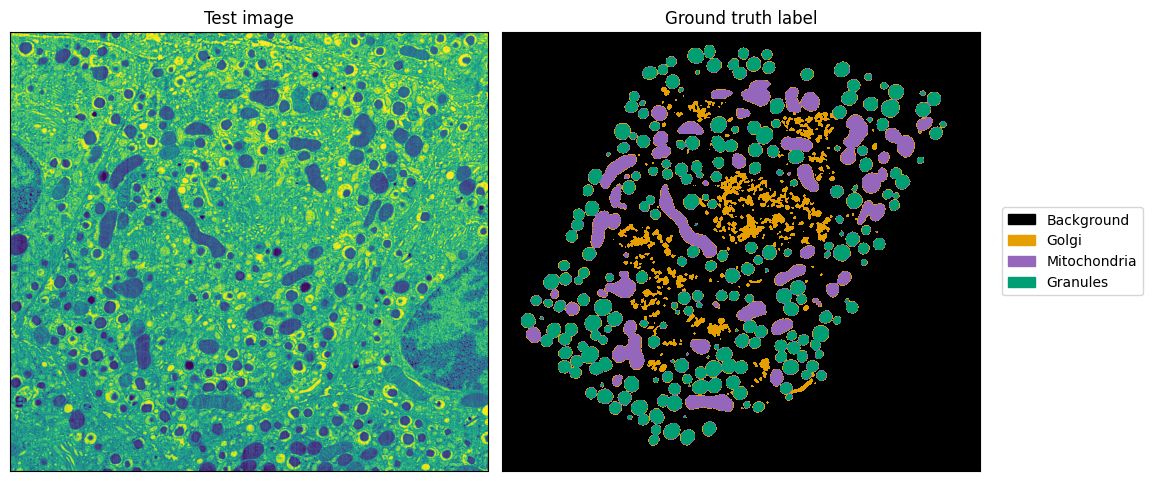

In [34]:
i = np.random.randint(0, len(test_images))
p.plot_wo_b((test_images[i], 'Test image', False),\
        (test_labels[i], 'Ground truth label', False),\
        plot_types=['imshow', 'imshow_l'],
        box_size=5
        )

## Extracting latent space from Encoder

In [35]:
golgi_mu, mitochondria_mu, granule_mu = np.empty((0, 43008)), np.empty((0, 43008)), np.empty((0, 43008))
FE = FeatureExtractor(model, patch_size, centre_size)
for idx in range(sample_size):
    mu = FE.get_feature_maps(golgi_samples[idx])
    golgi_mu = np.vstack([golgi_mu, mu])
    mu = FE.get_feature_maps(mito_samples[idx])
    mitochondria_mu = np.vstack([mitochondria_mu, mu])
    mu = FE.get_feature_maps(gra_samples[idx])
    granule_mu = np.vstack([granule_mu, mu])
train_mu = np.concatenate((golgi_mu, mitochondria_mu, granule_mu), axis=0)
train_labels = np.array([0] * 131 + [1] * 131 + [2] * 131)

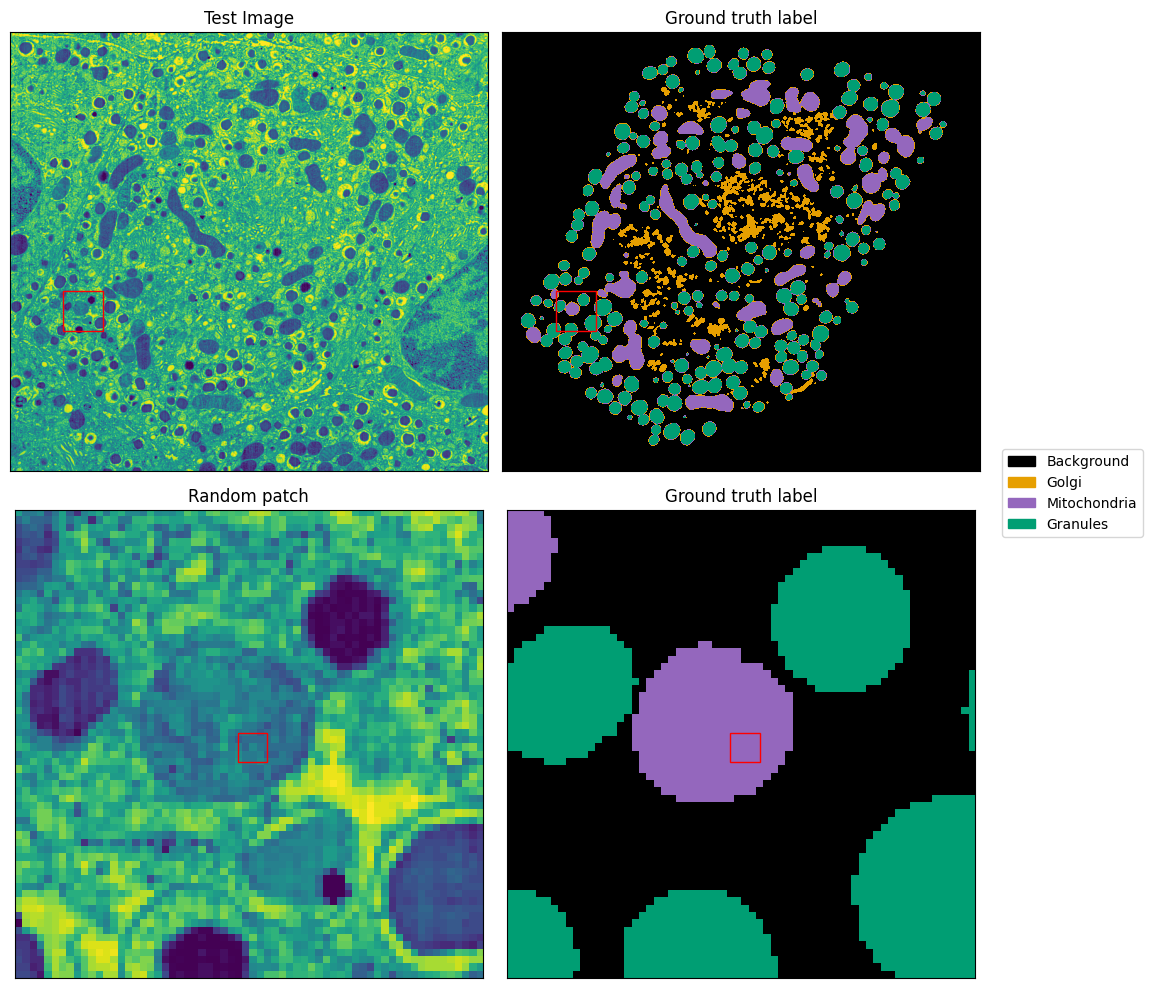

In [36]:
while True: 
        patch, label, y, x = dp.get_random_patch(test_images[i], test_labels[i], patch_size)
        centre = label[pad_size:pad_size+centre_size,pad_size:pad_size+centre_size]
        if 0 not in centre and np.unique(centre).size == 1:
                test_patch = patch
                test_label = label
                break
test_mu = FE.get_feature_maps(test_patch)
test_mu = np.expand_dims(test_mu, axis=0)

p.plot_wo_b( (test_images[i], "Test Image", (y, x, patch_size)),\
        (test_labels[i], "Ground truth label", (y, x, patch_size)),\
        (test_patch, "Random patch", (pad_size, pad_size, centre_size)),\
        (test_label, "Ground truth label", (pad_size, pad_size, centre_size)),\
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l'],
        box_size=5
        )
centre = np.unique(centre)[0]

## t-SNE

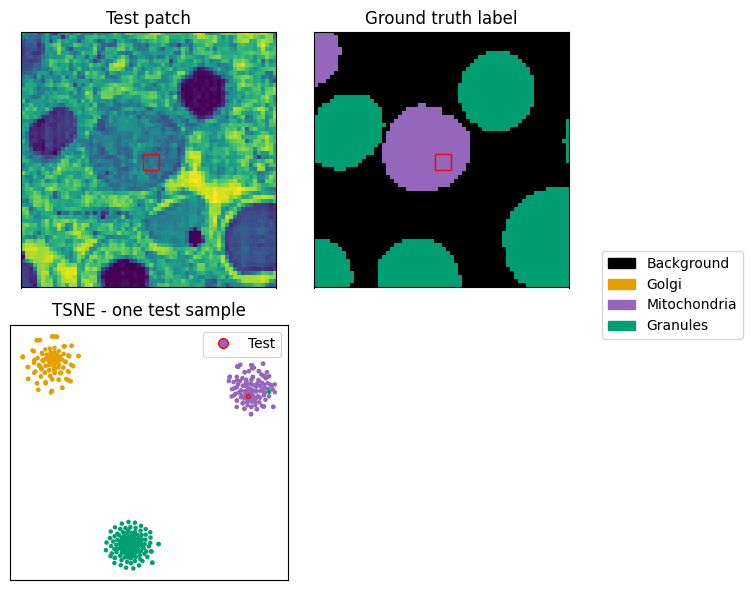

In [42]:
tsne = []
tsne = TSNE(
    n_components=2,
    random_state=42,
    learning_rate="auto",
    metric="euclidean",
    n_iter=10000,
).fit(train_mu)
golgi_tsne = tsne[:sample_size]
mitochondria_tsne = tsne[sample_size:2*sample_size]
granule_tsne = tsne[2*sample_size:]

golgi_tsne_mean = np.mean(golgi_tsne, axis=0)
mitochondria_tsne_mean = np.mean(mitochondria_tsne, axis=0)
granule_tsne_mean = np.mean(granule_tsne, axis=0)

test_tsne = tsne.transform(test_mu)
point_size = 5
p.plot_wo_b( (test_patch, "Test patch", (pad_size, pad_size, centre_size)),\
        (test_label, "Ground truth label", (pad_size, pad_size, centre_size)),\
        ([golgi_tsne, mitochondria_tsne, granule_tsne, test_tsne], "TSNE - one test sample",\
                 [([1]*sample_size,point_size), ([2]*sample_size,point_size),\
                   ([3]*sample_size,point_size), ([centre],point_size)]),\
        plot_types=['imshow', 'imshow_l', 'scatter'],
        )

## KMeans

In [46]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(train_mu)
train_labels_kmean = kmeans.labels_
test_kmeans = kmeans.transform(test_mu)

In [49]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
pca = PCA(n_components=200)
x_mu_reduced = pca.fit_transform(train_mu)
new_point_reduced = pca.transform(feature_map.reshape(1, -1))

scaler = StandardScaler()
mus_normalized = scaler.fit_transform(x_mu_reduced)

gmm = GaussianMixture(n_components=3, covariance_type='tied', random_state=0)
gmm.fit(mus_normalized)
new_mu_normalized = scaler.transform(new_point_reduced.reshape(1, -1))

probs = gmm.predict_proba(new_mu_normalized)
print(probs)

In [ ]:
labels_gmm = gmm.predict(mus_normalized)

In [ ]:
unique_labels, counts = np.unique(labels_gmm, return_counts=True)
print(unique_labels, counts)

In [ ]:
# Evaluate Agglomerative clustering
agg_ari = adjusted_rand_score(true_labels, agg_labels)
agg_nmi = normalized_mutual_info_score(true_labels, agg_labels)

print("Agglomerative Clustering ARI:", agg_ari)
print("Agglomerative Clustering NMI:", agg_nmi)

In [ ]:
begin = 250
end = 414
p.plot_wo_b((test_images[i][begin:end, begin:end], "Test image", False),\
            (test_labels[i][begin:end, begin:end], "GT label", False),\
            plot_types=['imshow', 'imshow_l'])

In [ ]:
h, w = test_images[i][begin:end, begin:end].shape
new_h, new_w = h - patch_size + 1, w - patch_size + 1
feature_maps = np.zeros((new_h, new_w))
all_patches, all_labels = dp.get_all_patches(test_images[i][begin:end, begin:end], test_labels[i][begin:end, begin:end], patch_size, stride=1)
idx = 0
for y in tqdm(range(new_h)):
    for x in range(new_w):
        mu = FE.get_feature_maps(all_patches[idx])
        feature_maps[y][x] = FE.get_closest(train_mu, mu)
        idx += 1

In [ ]:
plt.imshow(feature_maps)

In [ ]:
dp.save_pickle(f"feature_maps_{i}th_test_sample.pkl", feature_maps)
feature_maps = dp.load_pickle(f"feature_maps_{i}th_test_sample.pkl")

In [ ]:
result = np.where(test_labels[i][begin+pad_size:begin+pad_size+101, begin+pad_size:begin+pad_size+101] != 0, feature_maps, 0)

In [ ]:
p.plot_wo_b( (test_images[i][begin:end, begin:end], "Input", (pad_size, pad_size, 101)),\
        (test_labels[i][begin:end, begin:end], "GT label", (pad_size, pad_size, 101)),\
        (test_images[i][begin+pad_size:begin+pad_size+101, begin+pad_size:begin+pad_size+101], "Input cropped", False),\
        (test_labels[i][begin+pad_size:begin+pad_size+101, begin+pad_size:begin+pad_size+101], "GT label cropped", False),\
        (feature_maps, "Prediction", False),\
        (result, "Prediction with background", False),\
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l', 'imshow_l', 'imshow_l'])

In [ ]:
np.unique(feature_maps, return_counts=True)

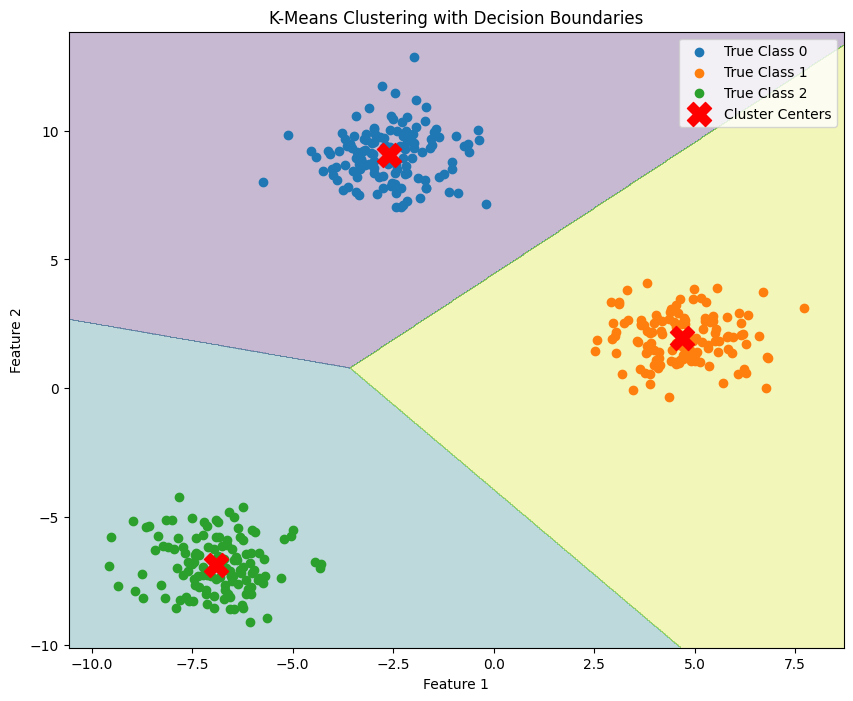

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

# Step 1: Generate Synthetic Data
X_train, true_labels = make_blobs(n_samples=393, centers=3, cluster_std=1.0, random_state=42)

# Step 2: Fit K-Means
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train)

# Step 3: Reduce Dimensionality to 2D using PCA (if necessary)
# For this example, the data is already 2D, so we skip PCA
X_train_reduced = X_train

# Step 4: Create a mesh grid and plot decision boundaries
h = .02  # step size in the mesh
x_min, x_max = X_train_reduced[:, 0].min() - 1, X_train_reduced[:, 0].max() + 1
y_min, y_max = X_train_reduced[:, 1].min() - 1, X_train_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3)

# Plot the data points with true labels
for i in range(num_clusters):
    cluster_points = X_train_reduced[true_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'True Class {i}')

# Plot the cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='X', label='Cluster Centers')

plt.title("K-Means Clustering with Decision Boundaries")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()
